# Importing libraries

In [1]:
!pip install tensorflow
!pip install dgl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import dgl
from dgl.nn import GraphConv
import matplotlib.pyplot as plt
import seaborn as sns
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.7 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install dgl torch

import dgl
import torch

print("DGL backend:", dgl.backend.get_preferred_backend())

DGL backend: pytorch


# Loading dataset

In [5]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/bb/psp/2018-06-06-pdb-intersect-pisces.csv')

# Preprocessing

# Dropping unnecessary column

In [6]:
df.drop_duplicates(subset='seq', inplace=True)

def clear_asterisks(df, seqs_column_name, pct=30):
    indices = []
    for i, seq in enumerate(df[seqs_column_name]):
        if (seq.count('*') * 100 / len(seq)) <= pct:
            indices.append(i)
            df.at[i, seqs_column_name] = seq.replace('*', '')
    return df.iloc[indices]

df = clear_asterisks(df, 'seq')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9078 non-null   object 
 1   chain_code     9078 non-null   object 
 2   seq            9078 non-null   object 
 3   sst8           9078 non-null   object 
 4   sst3           9078 non-null   object 
 5   len            9078 non-null   int64  
 6   has_nonstd_aa  9078 non-null   bool   
 7   Exptl.         9078 non-null   object 
 8   resolution     9078 non-null   float64
 9   R-factor       9078 non-null   float64
 10  FreeRvalue     9078 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 789.0+ KB


In [ ]:
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCBCCCCCCCCCCCCCC,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCBCCSCCCEECC,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHTC,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI,CCTTSCTTCSSTTSSTTCCC,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHTSSCSSCCCCEEC,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16


# Visualization

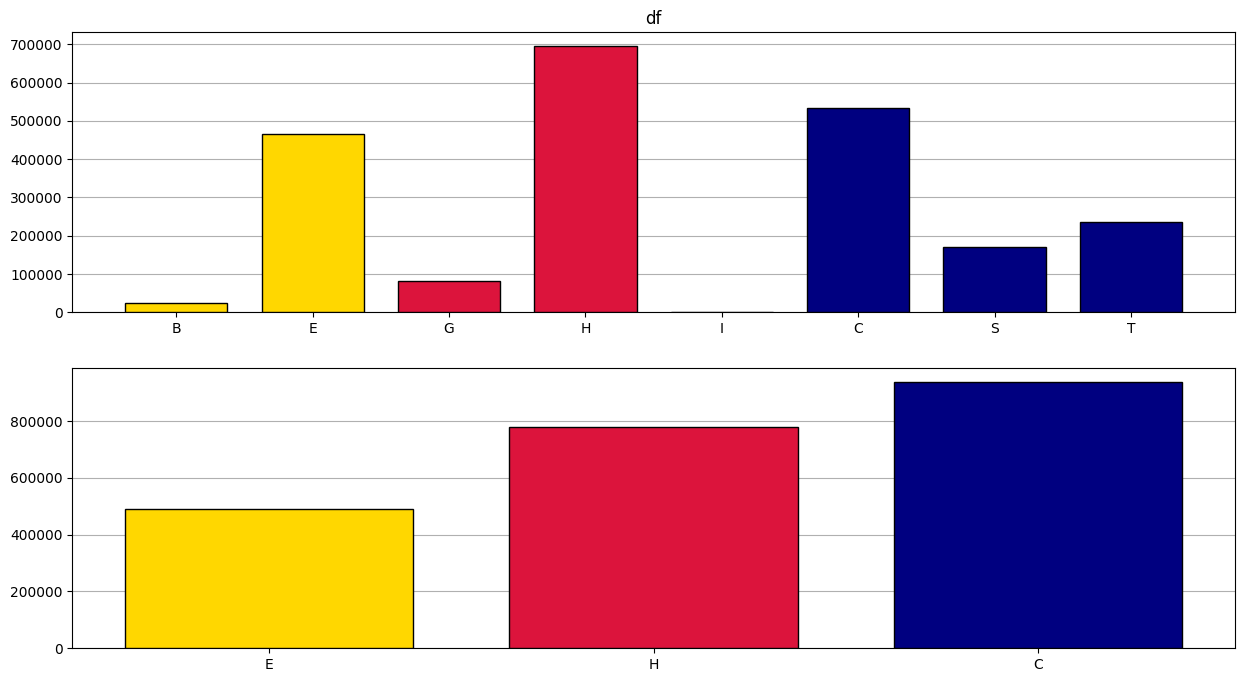

In [ ]:
from collections import defaultdict
SS_counts = {'df': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0)}}

for seq in df['sst8']:
    for ss in set(seq):
        SS_counts['df']['SST-8'][ss] += seq.count(ss)

for seq in df['sst3']:
    for ss in set(seq):
        SS_counts['df']['SST-3'][ss] += seq.count(ss)

ss8_types = ['B', 'E', 'G', 'H', 'I', 'C', 'S', 'T']
ss3_types = ['E', 'H', 'C']

sst8_colors = ['gold', 'gold', 'crimson', 'crimson', 'crimson', 'navy', 'navy', 'navy']
sst3_colors = ['gold', 'crimson', 'navy']

fig, axs = plt.subplots(2, 1, sharey = 'row', figsize = (15, 8))

axs[0].bar(range(8), height = [SS_counts['df']['SST-8'][ss] for ss in ss8_types],
          tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0].title.set_text('df')

axs[1].bar(range(3), height = [SS_counts['df']['SST-3'][ss] for ss in ss3_types],
          tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[1].grid(axis = 'y', which = 'both', zorder = 0)

fig.show()

In [ ]:
AA_counts = {'df': defaultdict(lambda: 0)}
for (seq, nonstd) in zip(df['seq'], df['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['df'][aa] += seq.count(aa)

total_aa = [AA_counts['df'][aa] for aa in AA_counts['df'].keys()]
temp = sorted(total_aa, reverse=True)
order = [total_aa.index(v) for v in temp]
aa_order = [list(AA_counts['df'].keys())[i] for i in order]

tbl_data = {'Amino Acid': aa_order,
            'df': [ round(AA_counts['df'][aa] / sum(AA_counts['df'].values()), 3) for aa in aa_order]}
pd.DataFrame(tbl_data)

,Amino Acid,df
0,L,0.091
1,A,0.082
2,G,0.073
3,V,0.068
4,E,0.067
5,S,0.063
6,D,0.059
7,K,0.056
8,I,0.055
9,T,0.054


<ipython-input-9-dc164e9afda5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='has_nonstd_aa', data=df, palette='pastel')


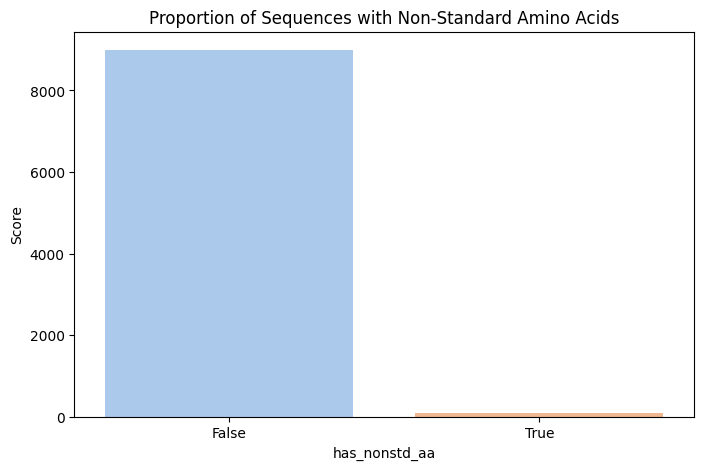

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='has_nonstd_aa', data=df, palette='pastel')
plt.title('Proportion of Sequences with Non-Standard Amino Acids')
plt.xlabel('has_nonstd_aa')
plt.ylabel('Score')
plt.show()

<ipython-input-10-66df7c512892>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_nonstd_aa', y='len', data=df, palette='pastel')


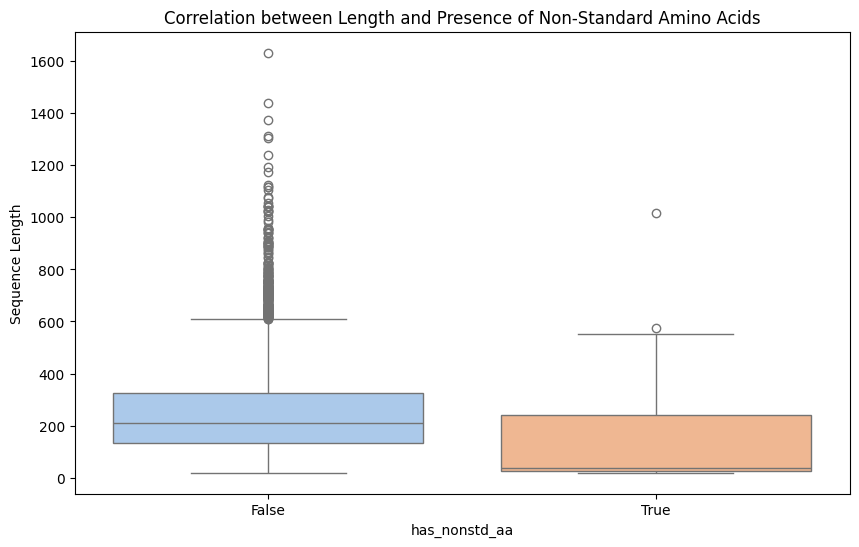

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_nonstd_aa', y='len', data=df, palette='pastel')
plt.title('Correlation between Length and Presence of Non-Standard Amino Acids')
plt.xlabel('has_nonstd_aa')
plt.ylabel('Sequence Length')
plt.show()

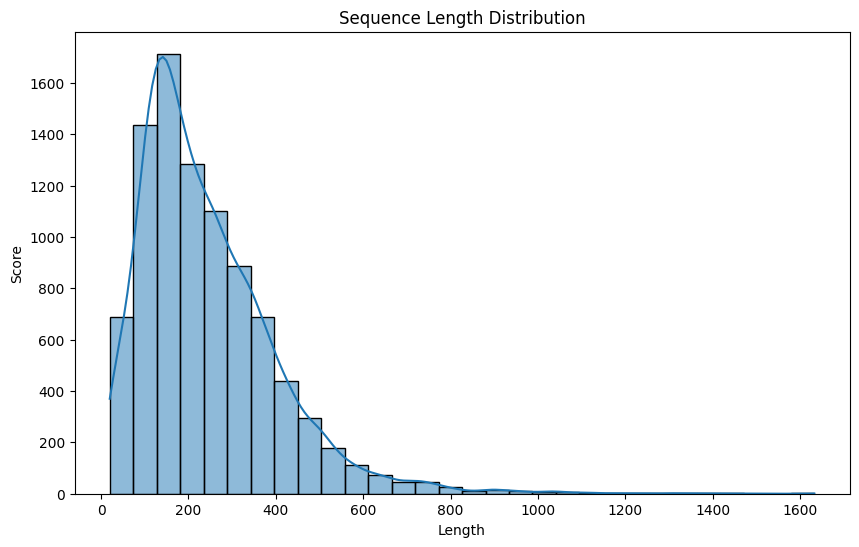

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['len'], bins=30, kde=True)
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Score')
plt.show()

dict_a:  {'C': 62277, 'H': 89142, 'E': 30648}
dict_f:  {'C': 27864, 'H': 31873, 'E': 28744}
dict_p:  {'C': 72342, 'H': 19469, 'E': 10004}
dict_s:  {'C': 73970, 'H': 38869, 'E': 25704}


Text(0.5, 1.0, 'Secondary Structure character counts for aminoacid S')

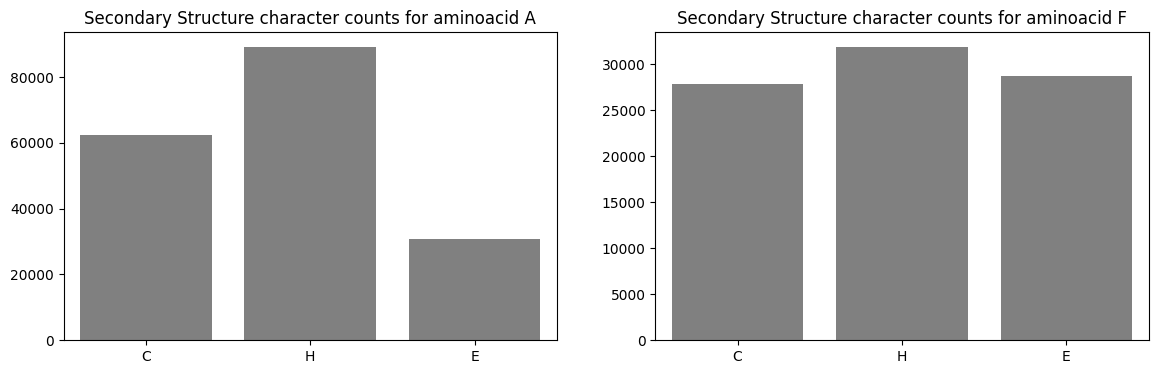

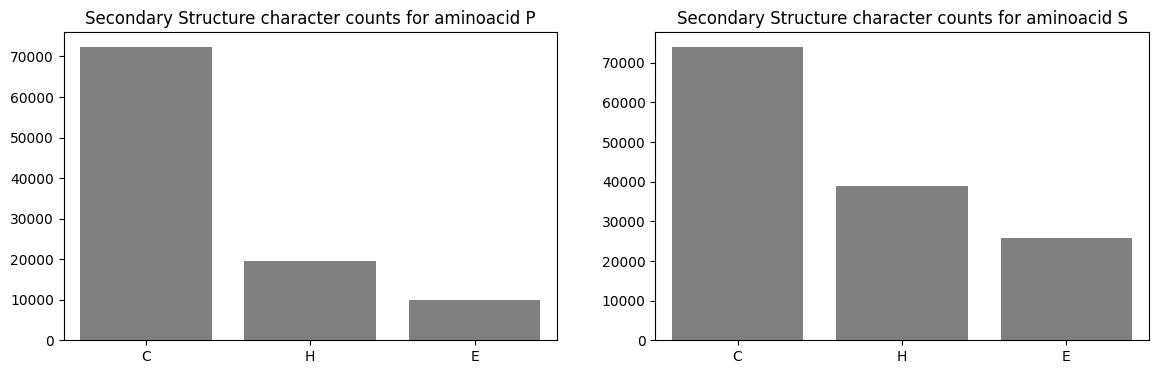

In [ ]:
dict_a = {'C': [], 'H': [], 'E': []}
dict_f = {'C': [], 'H': [], 'E': []}
dict_p = {'C': [], 'H': [], 'E': []}
dict_s = {'C': [], 'H': [], 'E': []}

for se, sst in zip(df['seq'], df['sst3']):
    for s, ss in zip(se, sst):
        if s == 'A':
            if ss == 'C':
                dict_a['C'].append(1)
            elif ss == 'H':
                dict_a['H'].append(1)
            elif ss == 'E':
                dict_a['E'].append(1)
        elif s == 'F':
            if ss == 'C':
                dict_f['C'].append(1)
            elif ss == 'H':
                dict_f['H'].append(1)
            elif ss == 'E':
                dict_f['E'].append(1)
        elif s == 'P':
            if ss == 'C':
                dict_p['C'].append(1)
            elif ss == 'H':
                dict_p['H'].append(1)
            elif ss == 'E':
                dict_p['E'].append(1)
        elif s == 'S':
            if ss == 'C':
                dict_s['C'].append(1)
            elif ss == 'H':
                dict_s['H'].append(1)
            elif ss == 'E':
                dict_s['E'].append(1)

for k in dict_a.keys():
    dict_a[k] = sum(dict_a[k])
for k in dict_f.keys():
    dict_f[k] = sum(dict_f[k])
for k in dict_p.keys():
    dict_p[k] = sum(dict_p[k])
for k in dict_s.keys():
    dict_s[k] = sum(dict_s[k])

print('dict_a: ', dict_a)
print('dict_f: ', dict_f)
print('dict_p: ', dict_p)
print('dict_s: ', dict_s)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=list(dict_a.keys()), y=list(dict_a.values()), color='gray')
plt.title('Secondary Structure character counts for aminoacid A')
plt.subplot(1, 2, 2)
sns.barplot(x=list(dict_f.keys()), y=list(dict_f.values()), color='gray')
plt.title('Secondary Structure character counts for aminoacid F')

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=list(dict_p.keys()), y=list(dict_p.values()), color='gray')
plt.title('Secondary Structure character counts for aminoacid P')
plt.subplot(1, 2, 2)
sns.barplot(x=list(dict_s.keys()), y=list(dict_s.values()), color='gray')
plt.title('Secondary Structure character counts for aminoacid S')

In [ ]:
#Sequence with majority length
length_values= df['len']
length_counts = length_values.value_counts()
print("Sequence Length      Counts:")
print(length_counts)

Sequence Length      Counts:
163     46
146     44
153     43
130     43
122     42
        ..
829      1
845      1
848      1
858      1
1117     1
Name: len, Length: 762, dtype: int64


# Preprocesssing

In [ ]:
df.drop_duplicates(subset='seq',inplace=True)
df.head()

def clear_asterisks (df, seqs_colum_name, pct=30):
  indices = []
  for i, seq in enumerate(df[seqs_colum_name ]):
    if (seq.count ('*')*100/len(seq)) <= pct: indices.append(i)
  return df.iloc[indices]

df = clear_asterisks(df, 'seq')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9078 non-null   object 
 1   chain_code     9078 non-null   object 
 2   seq            9078 non-null   object 
 3   sst8           9078 non-null   object 
 4   sst3           9078 non-null   object 
 5   len            9078 non-null   int64  
 6   has_nonstd_aa  9078 non-null   bool   
 7   Exptl.         9078 non-null   object 
 8   resolution     9078 non-null   float64
 9   R-factor       9078 non-null   float64
 10  FreeRvalue     9078 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 789.0+ KB


In [ ]:
df.drop_duplicates(subset='seq', inplace=True)

def clear_asterisks(df, seqs_column_name, pct=30):
    indices = []
    for i, seq in enumerate(df[seqs_column_name]):
        if (seq.count('*') * 100 / len(seq)) <= pct:
            indices.append(i)
            df.at[i, seqs_column_name] = seq.replace('*', '')
    return df.iloc[indices]

df = clear_asterisks(df, 'seq')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078 entries, 0 to 9077
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9078 non-null   object 
 1   chain_code     9078 non-null   object 
 2   seq            9078 non-null   object 
 3   sst8           9078 non-null   object 
 4   sst3           9078 non-null   object 
 5   len            9078 non-null   int64  
 6   has_nonstd_aa  9078 non-null   bool   
 7   Exptl.         9078 non-null   object 
 8   resolution     9078 non-null   float64
 9   R-factor       9078 non-null   float64
 10  FreeRvalue     9078 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 789.0+ KB


In [ ]:
amino_acid_to_int = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}

In [ ]:
# Split dataset into features and target
X = df['seq']
y = df['sst3']
def sequence_to_graph(sequence):
    # Create a graph with the number of nodes equal to the sequence length
    g = dgl.graph(([], []))
    g.add_nodes(len(sequence))
    # Add edges between consecutive amino acids to represent the sequence
    src = torch.arange(0, len(sequence) - 1, dtype=torch.int64)
    dst = torch.arange(1, len(sequence), dtype=torch.int64)
    g.add_edges(src, dst)
    g.add_edges(dst, src)  # Adding reverse edges for undirected graph
    features = torch.zeros(len(sequence), len(amino_acid_to_int))
    for i, aa in enumerate(sequence):
        if aa in amino_acid_to_int:
            features[i, amino_acid_to_int[aa]] = 1
        else:
            print(f"Non-standard amino acid '{aa}' found in sequence. Skipping this amino acid.")
    g.ndata['feat'] = features
    return g

X_graphs = [sequence_to_graph(seq) for seq in X]

In [ ]:
X_graphs

[Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=19, num_edges=36,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=20, num_edges=38,
       ndata_schemes={'feat': Sche

In [ ]:
# Converting sst3 to numerical labels
sst3_to_label = {'C': 0, 'E': 1, 'H': 2}
df['sst3_labels'] = df['sst3'].apply(lambda x: [sst3_to_label[aa] for aa in x])
def extract_node_features(sequence):
    features = []
    for token in sequence:
        feature = [int(token == aa) for aa in 'ACDEFGHIKLMNPQRSTVWY']
        features.append(feature)
    return np.array(features)

X_node_features = [extract_node_features(seq) for seq in X]

In [ ]:
X_node_features

[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_graphs_train = [sequence_to_graph(seq) for seq in X_train]
X_graphs_test = [sequence_to_graph(seq) for seq in X_test]

X_node_features_train = [extract_node_features(seq) for seq in X_train]
X_node_features_test = [extract_node_features(seq) for seq in X_test]

In [ ]:
max_nodes_train = max([graph.number_of_nodes() for graph in X_graphs_train])
max_nodes_test = max([graph.number_of_nodes() for graph in X_graphs_test])
max_nodes = max(max_nodes_train, max_nodes_test)
print(max_nodes)

1632


In [ ]:
def pad_adjacency_matrix(adj_matrix, max_nodes):
    num_nodes = adj_matrix.shape[0]
    padded_matrix = np.zeros((max_nodes, max_nodes))
    padded_matrix[:num_nodes, :num_nodes] = adj_matrix
    return padded_matrix

In [ ]:
import networkx as nx

def preprocess_data(sequences):
    graphs = []
    for seq in sequences:
        graph = nx.path_graph(len(seq))
        graphs.append(graph)
    return graphs

X_train_graphs = preprocess_data(X_train)
X_test_graphs = preprocess_data(X_test)

In [ ]:
!pip install networkx matplotlib

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_sequence_graph(sequence):
    G = nx.Graph()

    for i, amino_acid in enumerate(sequence):
        G.add_node(i, label=amino_acid)

    for i in range(len(sequence) - 1):
        G.add_edge(i, i + 1)

    return G

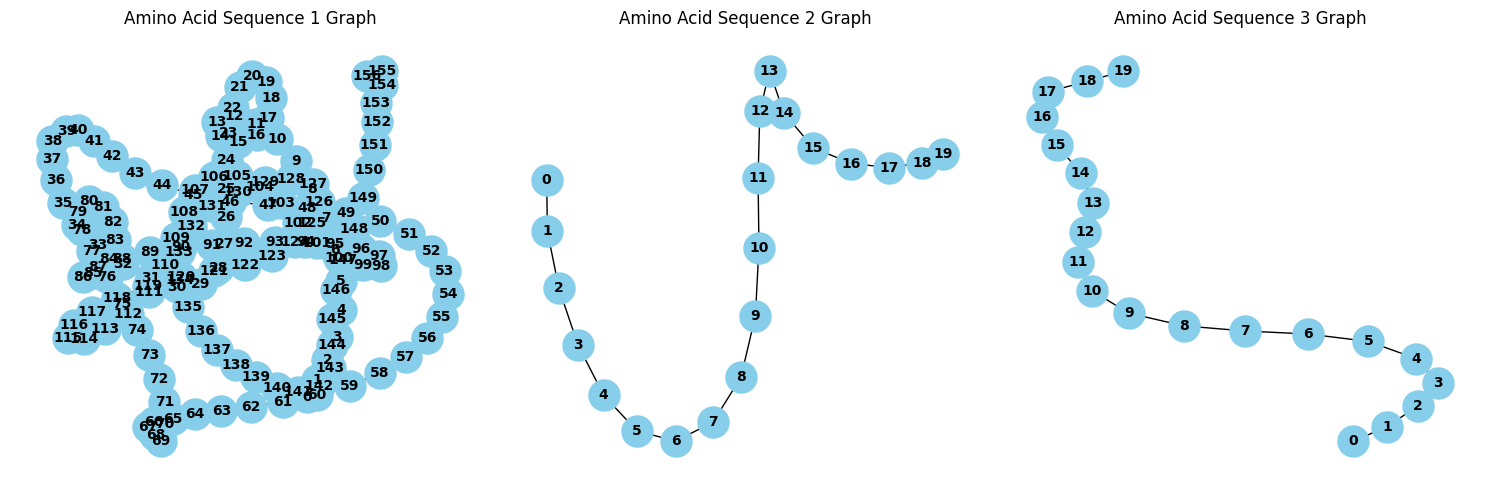

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_sequence_graphs(sequences):
    sequence_graphs = []
    for sequence in sequences:
        G = nx.Graph()

        for i, amino_acid in enumerate(sequence):
            G.add_node(i, label=amino_acid)

        for i in range(len(sequence) - 1):
            G.add_edge(i, i + 1)

        sequence_graphs.append(G)
    return sequence_graphs

X_test_graphs = ["MGSDKIHHHHHHMSQLEKAQAEYAGFIQEFQSAIISTISEQGIPNGSYAPFVIDDAKNIYIYVSGLAVHTKNIEANPLVNVLFVDDEAKTNQIFARRRLSFDCTATLIERESQKWNQVVDQFQERFGQIIEVLRGLADFRIFQLTPKEGRFVIGFGA", "DLDLEMLAPYIPMDDDFQLR", "EEDPDLKAAIQESLREAEEA"]

sequence_graphs = generate_sequence_graphs(X_test_graphs)

plt.figure(figsize=(15, 5))
for i, graph in enumerate(sequence_graphs):
    plt.subplot(1, len(sequence_graphs), i + 1)
    nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title(f"Amino Acid Sequence {i+1} Graph")
plt.tight_layout()
plt.show()


In [ ]:
unique_amino_acids = set()
for seq in X:
    unique_amino_acids.update(set(seq))
input_dim = len(unique_amino_acids)

unique_secondary_structure_classes = set()
for label in y:
    unique_secondary_structure_classes.update(set(label))
output_dim = len(unique_secondary_structure_classes)

print("input_dim:", input_dim)
print("output_dim:", output_dim)

input_dim: 20
output_dim: 3


# Model

In [ ]:
from sklearn.base import BaseEstimator

class GNN(BaseEstimator):
    def __init__(self, in_feats, hidden_size, batch_sizes, learning_rates, num_classes):
        self.in_feats = in_feats
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_sizes = batch_sizes
        self.learning_rates = learning_rates

    def fit(self, X, y):
        self.model = GNN(in_feats=self.in_feats, hidden_size=self.hidden_size, batch_sizes=self.batch_sizes, learning_rates=self.learning_rates, num_classes=self.num_classes)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.001)

        for epoch in range(20):
            for sequence, labels in zip(X, y):
                g = sequence_to_graph(sequence)
                inputs = g.ndata['feat']
                labels = torch.tensor(labels, dtype=torch.long)
                outputs = self.model(g, inputs)

                # Check if the tensors have the expected shapes
                if outputs.dim() == 0 or labels.dim() == 0:
                    continue
                if outputs.size(0) != labels.size(0):
                    continue

                loss = loss_func(outputs.unsqueeze(0), labels.unsqueeze(0))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        predictions = []
        self.model.eval()
        with torch.no_grad():
            for sequence in X:
                g = sequence_to_graph(sequence)
                inputs = g.ndata['feat']
                outputs = self.model(g, inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.append(predicted.item())
        return predictions

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'hidden_size': [32, 64, 128],
    'batch_sizes' : [32, 64, 128],
    'epochs' : [30, 60, 100],
    'learning_rates' : [0.001, 0.01, 0.1]
}

gnn_estimator = GNN(in_feats=len(amino_acid_to_int), hidden_size=64, num_classes=3)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=gnn_estimator, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)


Best parameters found:{'hidden_size': 32, 'batch_sizes':128,  'epochs':20, 'learning_rates' : 0.001}


In [7]:
best_model = GNN(in_feats=len(amino_acid_to_int), hidden_size=best_params['hidden_size'], num_classes=3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(best_model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(20):
    best_model.train()
    epoch_train_loss = 0
    correct_train = 0
    for sequence, label in zip(X_train, y_train):
        g = sequence_to_graph(sequence)
        inputs = g.ndata['feat'].unsqueeze(0)
        label = torch.tensor([label], dtype=torch.long)
        optimizer.zero_grad()
        outputs = best_model(g, inputs)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == label).sum().item()
    train_losses.append(epoch_train_loss / len(X_train))
    train_accuracies.append(correct_train / len(X_train))

    test_loss, test_accuracy = evaluate_model(best_model, X_test, y_test)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1,  Train Loss: 0.464849, Train Accuracy: 0.772693, Test Loss: 0.584849, Test Accuracy: 0.835643
Epoch 2,  Train Loss: 0.334216, Train Accuracy: 0.853893, Test Loss: 0.567028, Test Accuracy: 0.838677
Epoch 3,  Train Loss: 0.301314, Train Accuracy: 0.877090, Test Loss: 0.549207, Test Accuracy: 0.830012
Epoch 4,  Train Loss: 0.277920, Train Accuracy: 0.882144, Test Loss: 0.531386, Test Accuracy: 0.845046
Epoch 5,  Train Loss: 0.255717, Train Accuracy: 0.892821, Test Loss: 0.513565, Test Accuracy: 0.842148
Epoch 6,  Train Loss: 0.227491, Train Accuracy: 0.906062, Test Loss: 0.495744, Test Accuracy: 0.849690
Epoch 7,  Train Loss: 0.197702, Train Accuracy: 0.919861, Test Loss: 0.477923, Test Accuracy: 0.847836
Epoch 8,  Train Loss: 0.169625, Train Accuracy: 0.932163, Test Loss: 0.460102, Test Accuracy: 0.859179
Epoch 9,  Train Loss: 0.140738, Train Accuracy: 0.944644, Test Loss: 0.442281, Test Accuracy: 0.859500
Epoch 10, Train Loss: 0.116696, Train Accuracy: 0.954846, Test Loss: 0.42

# Accuracy and Loss Graph

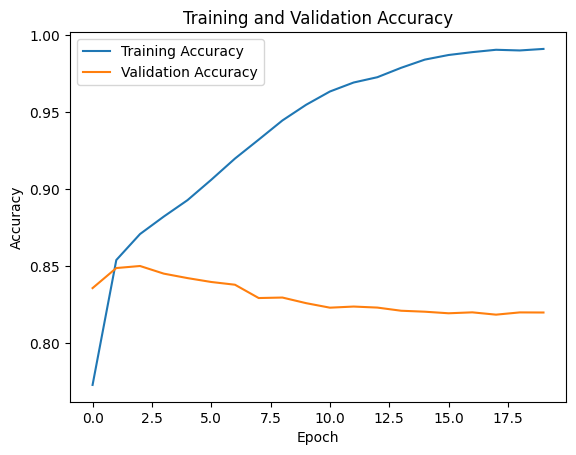

In [ ]:
plt.plot(epoch, train_accuracies, label='Training Accuracy')
plt.plot(epoch, test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

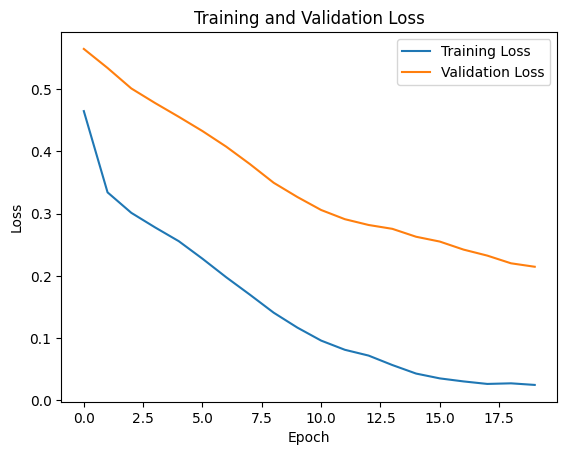

In [ ]:
plt.plot(epoch, train_accuracies, label='Training Loss')
plt.plot(epoch, test_accuracies, label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for graph, label in test_loader:
            output = model(graph, graph.ndata['feat'])
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == label).sum().item()
            total_samples += label.size(0)
    accuracy = total_correct / total_samples
    return accuracy

# Assuming you have defined test_loader
test_accuracy = evaluate(model, test_loader)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.84676567
